# Detección de Defectos en Imágenes con Autoencoder Convolucional (CAE)

**Autora:** Julia García Vega

**Fecha:** 14/07/2025

**Descripción:**
<br>
En este notebook se implementan variantes de autoencoder convolucional para la detección no supervisada de anomalías en imágenes industriales. El modelo se entrena exclusivamente con imágenes normales, con el objetivo de aprender una representación compacta que permita su reconstrucción fiel. Al evaluar imágenes que contienen defectos, la reconstrucción presenta fallos principalmente en las zonas anómalas, generando un mapa de error que posibilita la detección y localización de dichas anomalías.

Se exploran distintas arquitecturas y configuraciones de hiperparámetros para optimizar el desempeño del modelo, incluyendo el uso de conexiones tipo skip (similar a U-Net), variación en el tamaño del espacio latente, técnicas de regularización como dropout y L2, además de diferentes funciones de pérdida, como la sustitución de la pérdida MSE por pérdidas perceptuales (SSIM). También se considera la aplicación de técnicas de aumento de datos durante el entrenamiento para mejorar la robustez del modelo.

Este enfoque permite realizar tanto una clasificación binaria (imagen normal vs. anómala) basada en el error global, como una segmentación débil a nivel píxel mediante el análisis del error de reconstrucción. Para la evaluación se utiliza el dataset MVTec AD.


## Configuración inicial

In [25]:
from google.colab import files
import os
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.image import resize
from tensorflow.keras import layers
from PIL import Image
from tensorflow.keras import layers, models, losses, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from keras.saving import register_keras_serializable
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "/content/mvtec_dataset/cable"
IMG_SIZE = (256, 256)

## Importación de los datos

Se procede a descargar el conjunto de datos MVTec Anomaly Detection desde Kaggle, un dataset ampliamente utilizado para la detección de anomalías en imágenes industriales. Este conjunto incluye imágenes de diferentes objetos y texturas, con categorías que presentan ejemplos tanto de condiciones normales como de defectos.

Para este proyecto, se selecciona una categoría específica del dataset, en concreto cable, la cual contiene imágenes normales para entrenamiento y validación, junto con imágenes defectuosas agrupadas en distintas subcategorías. Además, se dispone de máscaras binarias en la carpeta de ground_truth que indican la ubicación exacta de los defectos para evaluación de segmentación.

Esta organización facilita la preparación y carga de datos para el entrenamiento no supervisado y la evaluación tanto de la detección como de la localización de anomalías.


In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juliagarve","key":"5649c5612324fd329c47d1502707613b"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d ipythonx/mvtec-ad

Dataset URL: https://www.kaggle.com/datasets/ipythonx/mvtec-ad
License(s): copyright-authors
100% 4.88G/4.91G [01:07<00:00, 88.7MB/s]
100% 4.91G/4.91G [01:07<00:00, 78.2MB/s]


In [6]:
!mkdir -p mvtec_dataset
!unzip -q mvtec-ad.zip -d mvtec_dataset/

In [7]:
def load_train_image_paths(train_dir):
    normal_dir = os.path.join(train_dir, "good")
    image_paths = sorted([os.path.join(normal_dir, f) for f in os.listdir(normal_dir)])
    return image_paths

def load_test_image_and_mask_paths(test_dir, gt_dir):
    image_paths = []
    mask_paths = []
    labels = []

    # Normales (sin máscara)
    normal_dir = os.path.join(test_dir, "good")
    normal_images = sorted([os.path.join(normal_dir, f) for f in os.listdir(normal_dir)])
    image_paths.extend(normal_images)
    mask_paths.extend([None] * len(normal_images))
    labels.extend([0] * len(normal_images))

    # Defectuosas con máscaras
    for defect in os.listdir(test_dir):
        if defect == "good":
            continue
        defect_dir = os.path.join(test_dir, defect)
        mask_dir = os.path.join(gt_dir, defect)
        defect_images = sorted([os.path.join(defect_dir, f) for f in os.listdir(defect_dir)])

        for img_path in defect_images:
            fname = os.path.basename(img_path)
            mask_path = os.path.join(mask_dir, fname).rsplit(".", 1)[0] + "_mask.png"
            image_paths.append(img_path)
            mask_paths.append(mask_path)
            labels.append(1)

    return image_paths, mask_paths, labels

In [8]:
train_dir = os.path.join(DATA_DIR, "train")
test_dir = os.path.join(DATA_DIR, "test")
gt_dir = os.path.join(DATA_DIR, "ground_truth")

train_image_paths = load_train_image_paths(train_dir)
test_image_paths, test_mask_paths, test_labels = load_test_image_and_mask_paths(test_dir, gt_dir)

In [9]:
print(f"Train images: {len(train_image_paths)}")
print(f"Test images: {len(test_image_paths)}")
print(f"Test masks: {len(test_mask_paths)}")
print(f"Test labels: {len(test_labels)}")

Train images: 224
Test images: 150
Test masks: 150
Test labels: 150


In [ ]:
print("Ejemplos de imágenes de entrenamiento:")
for path in train_image_paths[:3]:
    print(" -", path)

print("\nEjemplos de imágenes de test:")
for i in range(3):
    print(f" - {test_image_paths[i]} | Mask: {test_mask_paths[i]} | Label: {test_labels[i]}")
for i in range(-3, 0):
    print(f" - {test_image_paths[i]} | Mask: {test_mask_paths[i]} | Label: {test_labels[i]}")

Ejemplos de imágenes de entrenamiento:
 - /content/mvtec_dataset/cable/train/good/000.png
 - /content/mvtec_dataset/cable/train/good/001.png
 - /content/mvtec_dataset/cable/train/good/002.png

Ejemplos de imágenes de test:
 - /content/mvtec_dataset/cable/test/good/000.png | Mask: None | Label: 0
 - /content/mvtec_dataset/cable/test/good/001.png | Mask: None | Label: 0
 - /content/mvtec_dataset/cable/test/good/002.png | Mask: None | Label: 0
 - /content/mvtec_dataset/cable/test/combined/008.png | Mask: /content/mvtec_dataset/cable/ground_truth/combined/008_mask.png | Label: 1
 - /content/mvtec_dataset/cable/test/combined/009.png | Mask: /content/mvtec_dataset/cable/ground_truth/combined/009_mask.png | Label: 1
 - /content/mvtec_dataset/cable/test/combined/010.png | Mask: /content/mvtec_dataset/cable/ground_truth/combined/010_mask.png | Label: 1


## Preprocesamiento del conjunto de datos


In [10]:
train_paths, val_paths = train_test_split(train_image_paths, test_size=0.2, random_state=42)

In [11]:
def create_black_masks(image_paths, target_size=(256, 256), output_dir=None):
    os.makedirs(output_dir, exist_ok=True)
    for path in image_paths:
        fname = os.path.basename(path)
        mask_name = fname.rsplit('.', 1)[0] + "_mask.png"
        mask_path = os.path.join(output_dir, mask_name)

        if not os.path.exists(mask_path):
            black = np.zeros(target_size, dtype=np.uint8)
            Image.fromarray(black).save(mask_path)

In [12]:
create_black_masks(
    [p for i, p in enumerate(test_image_paths) if test_labels[i] == 0],
    target_size=(256, 256),
    output_dir=os.path.join(gt_dir, "good")
)

In [13]:
for i in range(len(test_image_paths)):
    if test_labels[i] == 0:
        fname = os.path.basename(test_image_paths[i])
        mask_name = fname.rsplit('.', 1)[0] + "_mask.png"
        test_mask_paths[i] = os.path.join(gt_dir, "good", mask_name)

In [14]:
def preprocess_image(path, target_size=(256, 256)):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def preprocess_mask(path, target_size=(256, 256)):
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, target_size)
    mask = tf.cast(mask, tf.float32) / 255.0
    return tf.squeeze(mask)

def augment_image(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img

def load_dataset(image_paths, augment=False, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(image_paths)
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    ds = ds.map(lambda x: (x, x), num_parallel_calls=tf.data.AUTOTUNE)
    return ds

def load_preprocessed_images_and_masks(image_paths, mask_paths, target_size=(256, 256)):
    originals = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        img_tensor = preprocess_image(img_path, target_size)
        mask_tensor = preprocess_mask(mask_path, target_size)

        originals.append(img_tensor.numpy())
        masks.append(mask_tensor.numpy())

    return np.array(originals), np.array(masks)

In [15]:
train_ds = load_dataset(train_paths, augment=True)
val_ds = load_dataset(val_paths, augment=False)
test_images, test_masks = load_preprocessed_images_and_masks(test_image_paths, test_mask_paths)

In [16]:
print(test_images.shape)
print(test_masks.shape)
print(len(test_labels))

(150, 256, 256, 3)
(150, 256, 256)
150


Batch shape: (32, 256, 256, 3)


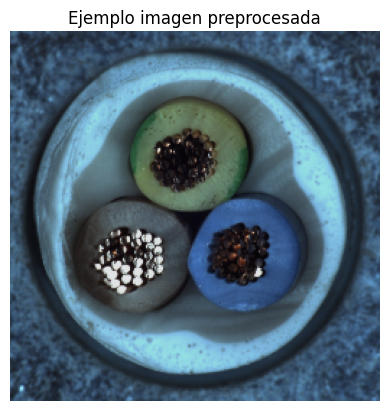

In [17]:
for batch in train_ds.take(1):
    images, targets = batch
    print("Batch shape:", images.shape)

    plt.imshow(images[0].numpy())
    plt.title("Ejemplo imagen preprocesada")
    plt.axis('off')
    plt.show()

## Construcción de arquitecturas

### CAE Básico

In [18]:
def build_basic_ae(input_shape=(256,256,3), embedding_dim=128):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)

    # Bottleneck
    shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
    flat_dim = int(np.prod(shape_before_flatten))
    x = layers.Flatten()(x)
    embedding = layers.Dense(embedding_dim, name='embedding')(x)

    # Decoder
    x = layers.Dense(flat_dim)(embedding)
    x = layers.Reshape(shape_before_flatten)(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)
    outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, outputs, name="basic_autoencoder")

    return model

In [20]:
basic_ae = build_basic_ae()

### VAE con residual connections

In [31]:
# Sampling layer
@register_keras_serializable()
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * epsilon

# VAE model
@register_keras_serializable()
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.beta = 1.0

    def compile(self, optimizer, beta=1.0):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.beta = beta

    def reconstruction_loss(self, x, x_recon):
        # MSE por imagen (suma sobre pixeles, media sobre batch)
        return tf.reduce_mean(tf.reduce_sum(tf.square(x - x_recon), axis=[1, 2, 3]))

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            mu, log_var = self.encoder(data)
            z = self.sampling((mu, log_var))
            reconstruction = self.decoder(z)
            recon_loss = self.reconstruction_loss(data, reconstruction)
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {"loss": self.total_loss_tracker.result()}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        mu, log_var = self.encoder(data)
        z = self.sampling((mu, log_var))
        reconstruction = self.decoder(z)
        recon_loss = self.reconstruction_loss(data, reconstruction)
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1))
        total_loss = recon_loss + self.beta * kl_loss
        return {"loss": total_loss}

    def call(self, inputs):
        mu, log_var = self.encoder(inputs)
        z = self.sampling((mu, log_var))
        return self.decoder(z)

In [32]:
# Bloque residual robusto y simétrico
def residual_block(x, filters):
    shortcut = x
    x_channels = K.int_shape(x)[-1]

    if x_channels != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, padding="same")(shortcut)

    x = layers.Conv2D(filters, 3, padding="same", activation='relu')(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# Encoder residual
def build_encoder_residual(latent_dim=64, input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(inputs)   # 128x128
    x = residual_block(x, 64)

    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)       # 64x64
    x = residual_block(x, 128)

    x = layers.Flatten()(x)
    mu = layers.Dense(latent_dim, name="mu")(x)
    log_var = layers.Dense(latent_dim, name="log_var")(x)

    return Model(inputs, [mu, log_var], name="encoder_residual")

# Decoder residual (simétrico)
def build_decoder_residual(latent_dim=64):
    latent_inputs = layers.Input(shape=(latent_dim,))

    x = layers.Dense(64 * 64 * 128, activation='relu')(latent_inputs)
    x = layers.Reshape((64, 64, 128))(x)  # Match encoder's final feature map
    x = residual_block(x, 128)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)  # 128x128
    x = residual_block(x, 64)

    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)  # 256x256
    x = residual_block(x, 32)

    x = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)  # Final output

    return Model(latent_inputs, x, name="decoder_residual")

In [33]:
encoder = build_encoder_residual(latent_dim=32)
decoder = build_decoder_residual(latent_dim=32)
residual_vae = VAE(encoder, decoder, name=f"residual_vae_ld32_beta2")

## Entrenamiento

In [34]:
def plot_training_history(history):
    history_dict = history.history
    epochs = range(1, len(history_dict['loss']) + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history_dict['loss'], label='Train Loss', marker='o')

    val_loss_key = 'val_loss'
    if val_loss_key in history_dict:
        plt.plot(epochs, history_dict[val_loss_key], label='Val Loss', marker='x')

    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### CAE Básico

In [35]:
basic_ae.compile(optimizer='adam', loss='mse')

os.makedirs("models", exist_ok=True)
checkpoint_path = os.path.join("models", f'best_model_{basic_ae.name}.keras')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

history_basic_ae = basic_ae.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=callbacks)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - loss: 0.0582 - val_loss: 0.0535 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 941ms/step - loss: 0.0572 - val_loss: 0.0509 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.0488 - val_loss: 0.0367 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.0386 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 897ms/step - loss: 0.0317 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 975ms/step - loss: 0.0235 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 358ms/step - loss: 0.0220 - val_loss: 0.0193 - learning_rate: 0.0010
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step - loss: 0.0216 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 670ms/step - loss: 0.0216 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 10/100
6/6 ━━━

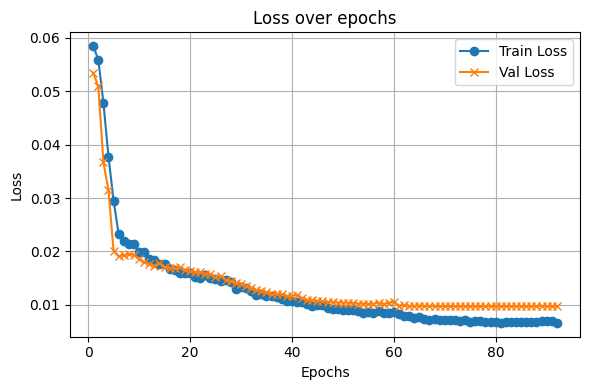

In [36]:
plot_training_history(history_basic_ae)

### VAE con residual connections

In [38]:
residual_vae.compile(optimizer=tf.keras.optimizers.Adam(), beta=2)

checkpoint_path = os.path.join("models", f'best_model_{residual_vae.name}.keras')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

residual_vae_history = residual_vae.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=callbacks)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 98091.3906    

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - loss: 94178.0078 - val_loss: 7844.8833 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 8298.0879 - val_loss: 6844.9551 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 7003.8149 - val_loss: 6393.8398 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 584ms/step - loss: 6838.2466 - val_loss: 9927.4883 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 8018.2188 - val_loss: 5889.6875 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 5915.7017 - val_loss: 4266.7017 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 4800.5127 - val_loss: 3832.0291 - learning_rate: 0.0010
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 4228.3047 - val_loss: 3575.3806 - learning_rate: 0.0010
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 609ms/step - loss: 4078.1836 - val_loss: 3837.7612 - learning_ra

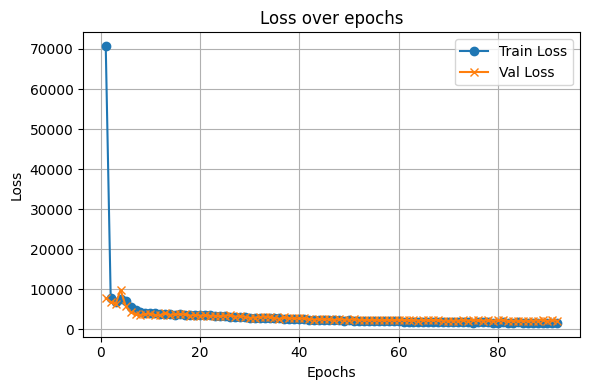

In [39]:
plot_training_history(residual_vae_history)

## Evaluación y comparativa de los modelos

In [41]:
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 1.0

def dice_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    return 2 * intersection / (y_true.sum() + y_pred.sum()) if (y_true.sum() + y_pred.sum()) != 0 else 1.0

def compute_error_maps_and_scores(model, originals):
    reconstructed = model.predict(originals)
    error_maps = np.mean((originals - reconstructed) ** 2, axis=-1)  # (N, H, W)
    scores = np.mean(error_maps, axis=(1, 2))  # (N,)
    return reconstructed, error_maps, scores

def compute_image_metrics(labels, scores, threshold=None):
    labels = np.array(labels)
    if threshold is None:
        threshold = np.percentile(scores[labels == 0], 95)
        print(f"Umbral automático (95% good): {threshold:.4f}")
    y_pred = scores > threshold

    cm = confusion_matrix(labels, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Defecto"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Matriz de Confusión")
    plt.show()

    image_auc = roc_auc_score(labels, scores)
    print(f"\nROC-AUC (imagen): {image_auc:.4f}")

    return y_pred, threshold

def compute_pixel_metrics(masks, labels, error_maps, threshold):
    labels = np.array(labels)
    mask_flat = masks[labels == 1].reshape(-1)
    errors_flat = error_maps[labels == 1].reshape(-1)
    pixel_auc = roc_auc_score(mask_flat > 0.5, errors_flat)
    print(f"ROC-AUC (pixel): {pixel_auc:.4f}")

    predicted_masks = error_maps > threshold

    y_true_pixels = masks.reshape(-1) > 0.5
    y_pred_pixels = predicted_masks.reshape(-1)

    precision = precision_score(y_true_pixels, y_pred_pixels)
    recall = recall_score(y_true_pixels, y_pred_pixels)
    f1 = f1_score(y_true_pixels, y_pred_pixels)
    iou = iou_score(y_true_pixels, y_pred_pixels)
    dice = dice_score(y_true_pixels, y_pred_pixels)

    print(f"\nMétricas a nivel pixel:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"IoU: {iou:.4f}")
    print(f"Dice: {dice:.4f}")

    return predicted_masks

def plot_comparison_examples(originals, reconstructed1, error_maps1, predicted_masks1,
                             reconstructed2, error_maps2, predicted_masks2,
                             masks, labels, y_pred1, y_pred2, model_names=("Model 1", "Model 2")):
    random_indices = np.random.choice(len(originals), size=3, replace=False)
    for i in random_indices:
        plt.figure(figsize=(18, 6))

        # Original
        plt.subplot(2, 4, 1)
        plt.imshow(originals[i])
        plt.title("Original")
        plt.axis('off')

        # Model 1
        plt.subplot(2, 4, 2)
        plt.imshow(reconstructed1[i])
        plt.title(f"{model_names[0]} Recon")
        plt.axis('off')

        plt.subplot(2, 4, 3)
        plt.imshow(error_maps1[i], cmap='hot')
        plt.title(f"{model_names[0]} Error")
        plt.axis('off')

        plt.subplot(2, 4, 4)
        plt.imshow(predicted_masks1[i], cmap='gray')
        plt.title(f"{model_names[0]} Pred Mask")
        plt.axis('off')

        # Model 2
        plt.subplot(2, 4, 6)
        plt.imshow(reconstructed2[i])
        plt.title(f"{model_names[1]} Recon")
        plt.axis('off')

        plt.subplot(2, 4, 7)
        plt.imshow(error_maps2[i], cmap='hot')
        plt.title(f"{model_names[1]} Error")
        plt.axis('off')

        plt.subplot(2, 4, 8)
        plt.imshow(predicted_masks2[i], cmap='gray')
        plt.title(f"{model_names[1]} Pred Mask")
        plt.axis('off')

        # Ground truth
        plt.subplot(2, 4, 5)
        plt.imshow(masks[i], cmap='gray')
        plt.title("GT Mask")
        plt.axis('off')

        plt.suptitle(
            f"Label: {'Defecto' if labels[i] == 1 else 'Normal'}\n"
            f"{model_names[0]} Pred: {'Defecto' if y_pred1[i] else 'Normal'} | "
            f"{model_names[1]} Pred: {'Defecto' if y_pred2[i] else 'Normal'}"
        )
        plt.tight_layout()
        plt.show()

In [42]:
reconstructed_basic_ae, error_maps_basic_ae, scores_basic_ae = compute_error_maps_and_scores(basic_ae, test_images)
reconstructed_residual_vae, error_maps_residual_vae, scores_residual_vae = compute_error_maps_and_scores(residual_vae, test_images)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


Umbral automático (95% good): 0.0128

==> Métricas IMAGEN para CAE Básico


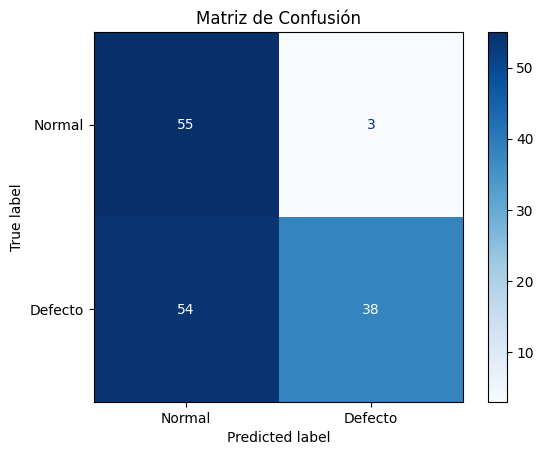


ROC-AUC (imagen): 0.7899
              precision    recall  f1-score   support

      Normal       0.50      0.95      0.66        58
     Defecto       0.93      0.41      0.57        92

    accuracy                           0.62       150
   macro avg       0.72      0.68      0.62       150
weighted avg       0.76      0.62      0.61       150


==> Métricas IMAGEN para VAE con residual connections


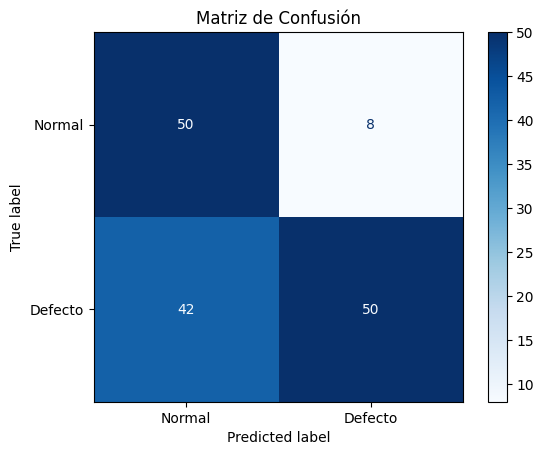


ROC-AUC (imagen): 0.7957
              precision    recall  f1-score   support

      Normal       0.54      0.86      0.67        58
     Defecto       0.86      0.54      0.67        92

    accuracy                           0.67       150
   macro avg       0.70      0.70      0.67       150
weighted avg       0.74      0.67      0.67       150



In [47]:
# Umbral automático a partir del modelo básico (por ejemplo)
labels = np.array(test_labels)
threshold = np.percentile(scores_basic_ae[labels == 0], 95)
print(f"Umbral automático (95% good): {threshold:.4f}")

# Calcular predicciones con ese umbral
print("\n==> Métricas IMAGEN para CAE Básico")
y_pred_basic_ae, _ = compute_image_metrics(test_labels, scores_basic_ae, threshold)
print(classification_report(test_labels, y_pred_basic_ae, target_names=["Normal", "Defecto"]))
print("\n==> Métricas IMAGEN para VAE con residual connections")
y_pred_residual_vae, _ = compute_image_metrics(test_labels, scores_residual_vae, threshold)
print(classification_report(test_labels, y_pred_residual_vae, target_names=["Normal", "Defecto"]))

In [48]:
print("\n==> Métricas PIXEL para CAE Básico")
predicted_masks_basic = compute_pixel_metrics(test_masks, test_labels, error_maps_basic_ae, threshold)

print("\n==> Métricas PIXEL para VAE con residual connections")
predicted_masks_residual = compute_pixel_metrics(test_masks, test_labels, error_maps_residual_vae, threshold)


==> Métricas PIXEL para CAE Básico
ROC-AUC (pixel): 0.8241

Métricas a nivel pixel:
Precision: 0.1044
Recall: 0.6832
F1-score: 0.1811
IoU: 0.0996
Dice: 0.1811

==> Métricas PIXEL para VAE con residual connections
ROC-AUC (pixel): 0.8406

Métricas a nivel pixel:
Precision: 0.1017
Recall: 0.7591
F1-score: 0.1793
IoU: 0.0985
Dice: 0.1793


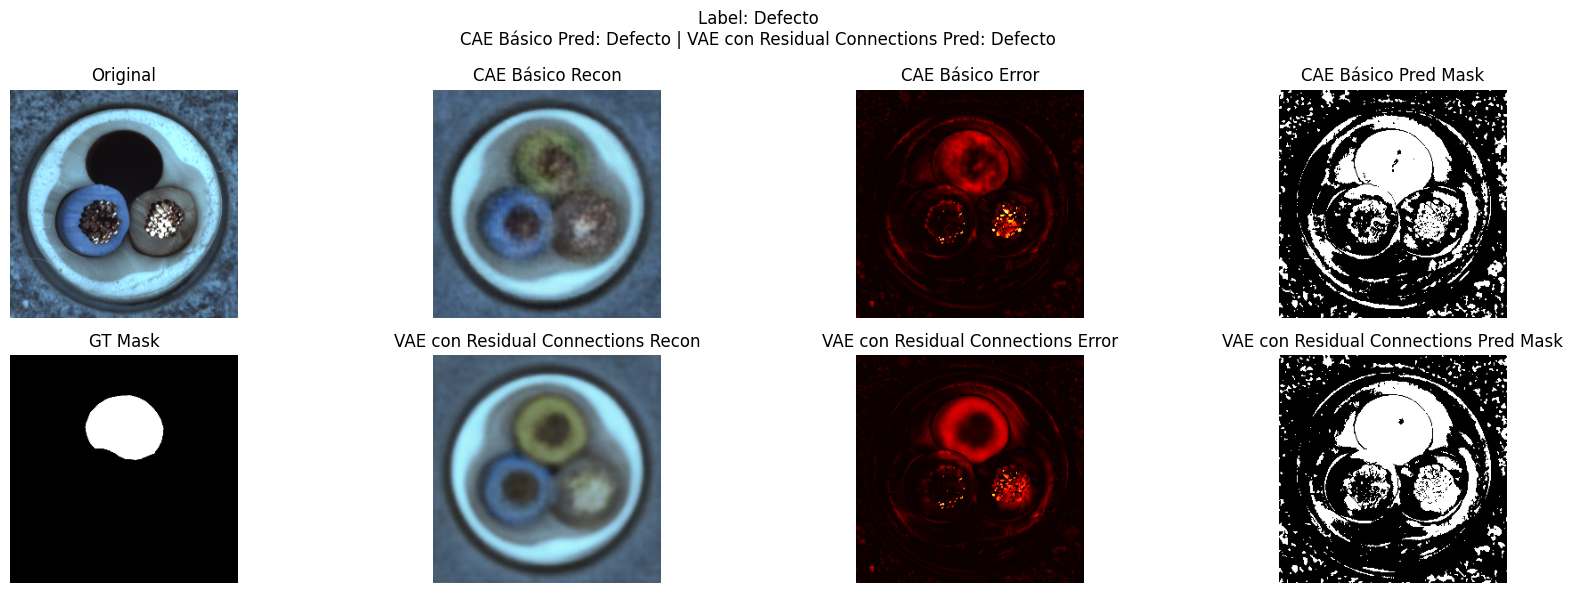

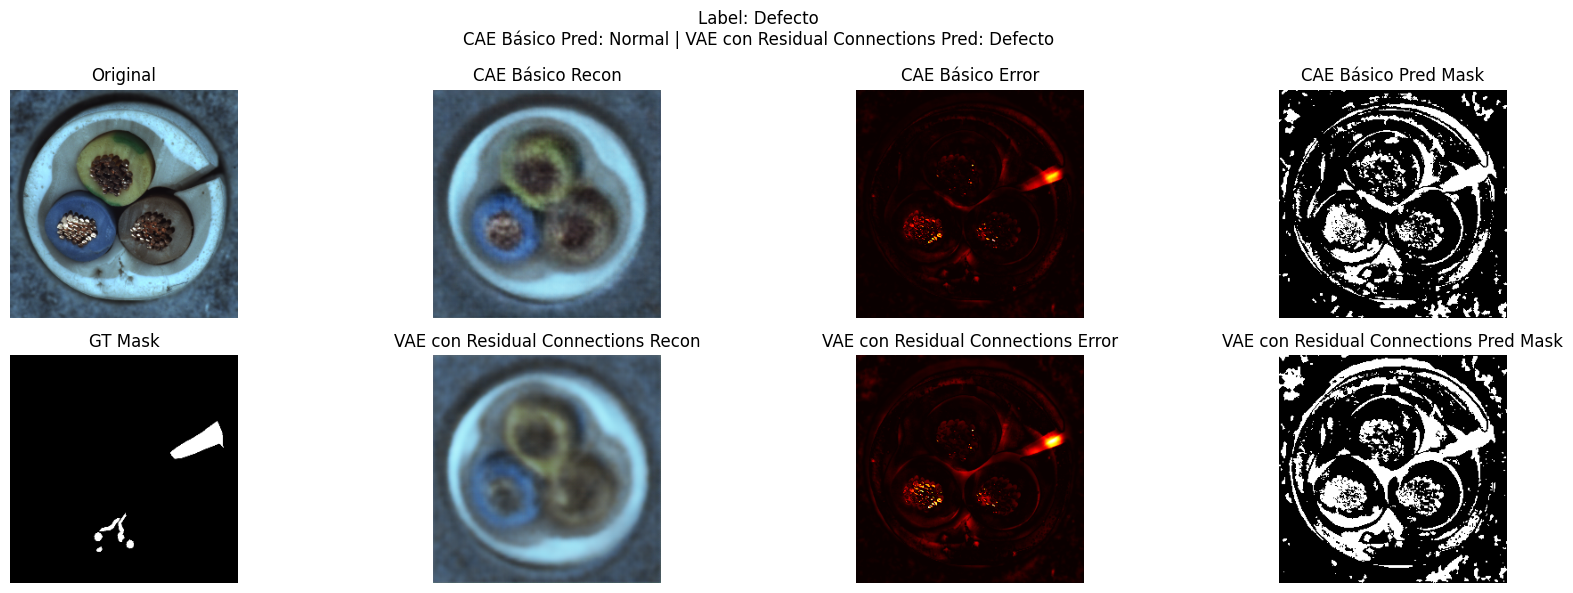

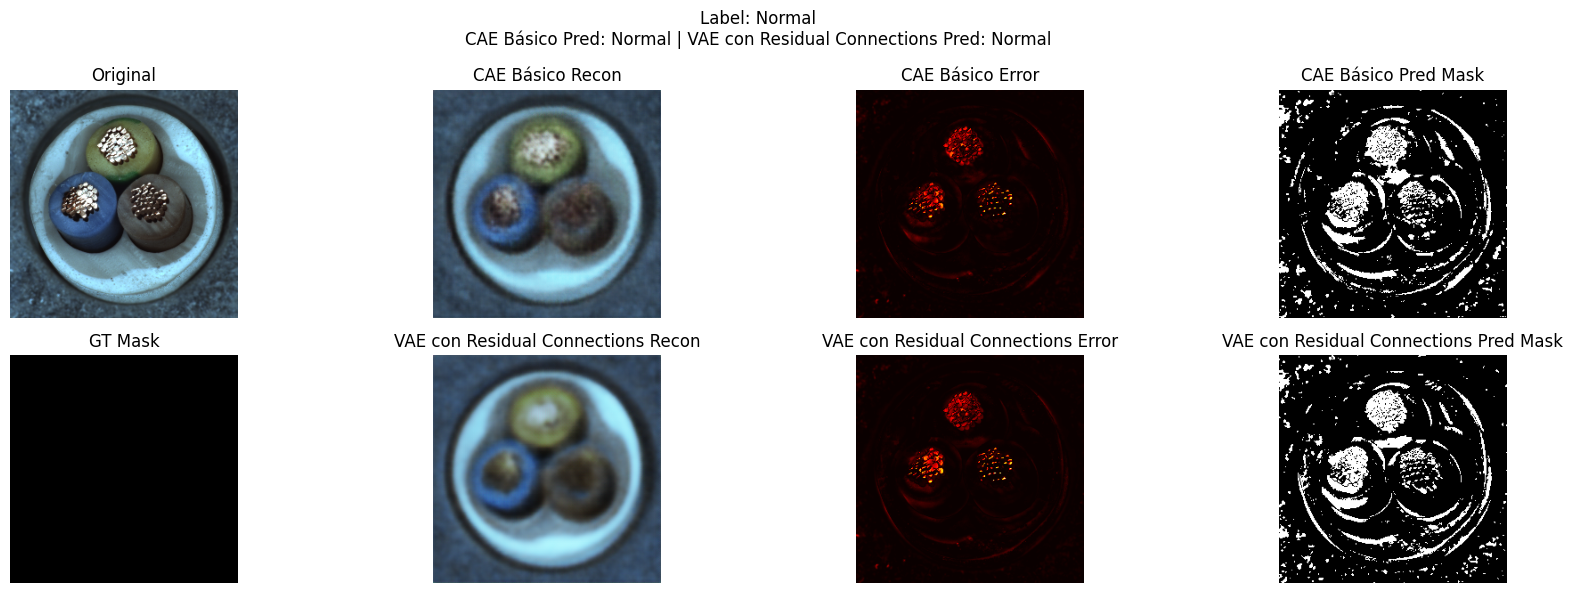

In [46]:
plot_comparison_examples(
    test_images,
    reconstructed_basic_ae, error_maps_basic_ae, predicted_masks_basic,
        reconstructed_residual_vae, error_maps_residual_vae, predicted_masks_residual,
    test_masks, test_labels,
    y_pred_basic_ae, y_pred_residual_vae,
    model_names=("CAE Básico", "VAE con Residual Connections")
)